# Minimum Daily Temperatures Dataset

Australian Bureau of Meteorology

Temperaturas medidas ao longo de  10 anos (1981-1990) na cidade de   Melbourne, Australia.

Os modelos utilizados são do pacote de modelos probabilisticos para séries temporais focados em deep learning [GluonTS](https://ts.gluon.ai/).

In [ ]:
%%capture
!pip install mxnet
!pip install gluonts
!pip install EMD-signal

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

from sklearn.metrics import mean_absolute_error, mean_squared_error

from PyEMD import EMD

In [ ]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"

df = pd.read_csv(url)

df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")

In [ ]:
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3650 non-null   datetime64[ns]
 1   Temp    3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


Separando em treino e teste.

In [ ]:
test_len = int(0.2*len(df))

In [ ]:
df_train, df_test = df.iloc[:-test_len, :], df.iloc[-test_len:, :]

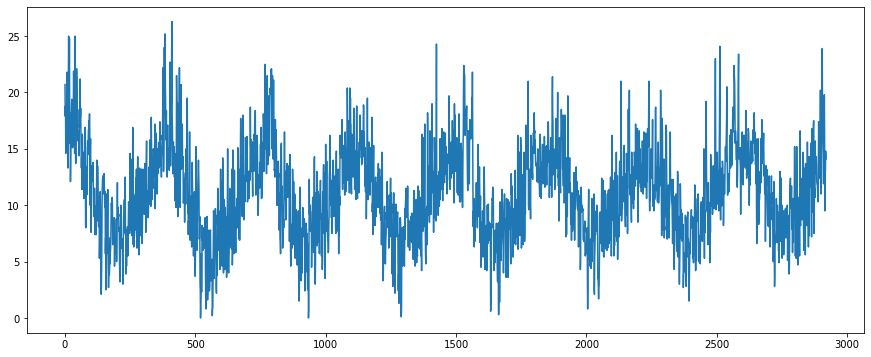

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df_train['Temp'])

Criando o dataset do GluonTS

In [ ]:
from gluonts.dataset.common import ListDataset

training_data = ListDataset(
    [{"start": df.Date[0], "target": df_train['Temp']}],
    freq = "D"
)

O primeiro modelo é o DeepAR, um modelo probabilistico autoregressivo com redes neurais recorrentes. O modelo é descrito em: https://arxiv.org/abs/1704.04110

In [ ]:
estimator = DeepAREstimator(freq="D", prediction_length=test_len, trainer=Trainer(epochs=10))
predictor = estimator.train(training_data=training_data)

100%|██████████| 50/50 [02:01<00:00,  2.44s/it, epoch=10/10, avg_epoch_loss=2.25]


Gerando previsões e avaliando o modelo no conjunto de testes.

In [ ]:
preds = next(predictor.predict(training_data, num_samples=100))

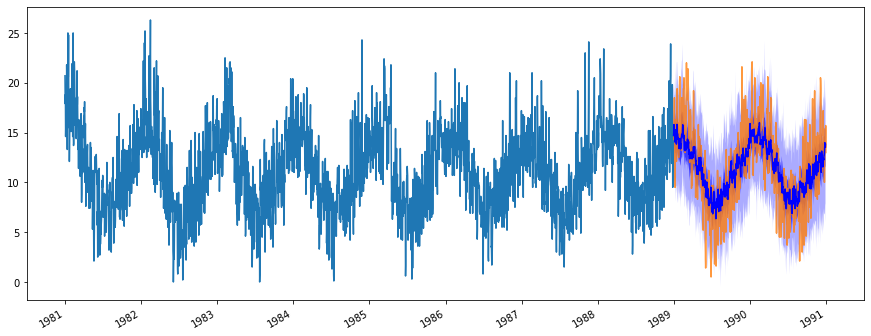

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df_train['Date'].tail(test_len*4), df_train['Temp'].tail(test_len*4))
plt.plot(df_test['Date'], df_test['Temp'], alpha=0.8)
#plt.plot(df_test['Date'], preds.mean)
preds.plot(prediction_intervals=(50.0, 95.0))

In [ ]:
print(mean_absolute_error(df_test['Temp'], preds.mean))
mean_absolute_error(df_test['Temp'], preds.median)

2.176273151423833


2.1776350845702708

O modelo seguinte é uma impelementação de um "deep state space model", descrito no paper: https://papers.nips.cc/paper/2018/file/5cf68969fb67aa6082363a6d4e6468e2-Paper.pdf

In [ ]:
from gluonts.model.deep_factor import DeepFactorEstimator

In [ ]:
estimator = DeepFactorEstimator(freq="D", prediction_length=test_len, trainer=Trainer(epochs=15))
predictor = estimator.train(training_data=training_data)

100%|██████████| 50/50 [00:06<00:00,  7.58it/s, epoch=15/15, avg_epoch_loss=2.55]


In [ ]:
preds = next(predictor.predict(training_data, num_samples=100))

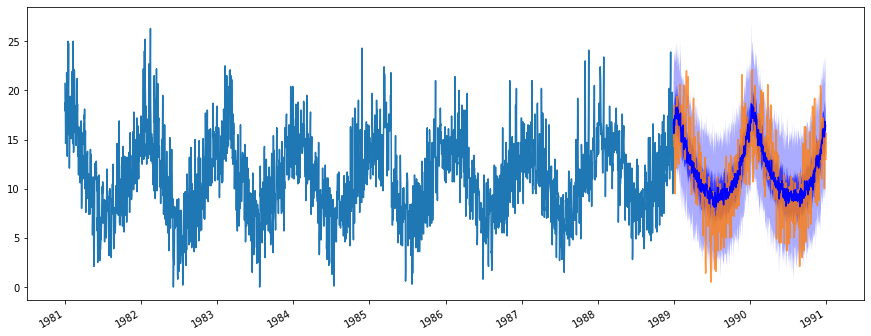

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df_train['Date'].tail(test_len*4), df_train['Temp'].tail(test_len*4))
plt.plot(df_test['Date'], df_test['Temp'], alpha=0.8)
#plt.plot(df_test['Date'], preds.mean)
preds.plot(prediction_intervals=(50.0, 95.0))

In [ ]:
print(mean_absolute_error(df_test['Temp'], preds.mean))
print(mean_absolute_error(df_test['Temp'], preds.median))

2.3414785549738633
2.345473976657815


Por fim, é utilizada uma implementação simples de rede neural feed-forward.

In [ ]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator

In [ ]:
estimator = SimpleFeedForwardEstimator(freq="D", prediction_length=test_len,
                                     trainer=Trainer(epochs=10))
predictor = estimator.train(training_data=training_data)

100%|██████████| 50/50 [00:02<00:00, 24.74it/s, epoch=10/10, avg_epoch_loss=2.46]


In [ ]:
preds = next(predictor.predict(training_data, num_samples=100))

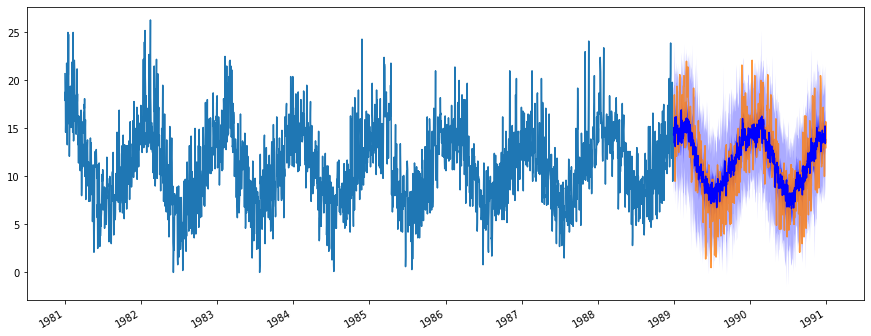

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df_train['Date'].tail(test_len*4), df_train['Temp'].tail(test_len*4))
plt.plot(df_test['Date'], df_test['Temp'], alpha=0.8)
#plt.plot(df_test['Date'], preds.mean)
preds.plot(prediction_intervals=(50.0, 95.0))

In [ ]:
print(mean_absolute_error(df_test['Temp'], preds.mean))
print(mean_absolute_error(df_test['Temp'], preds.median))

2.1807802270863155
2.174509949749463
